In [1]:
#import libraries
from geopandas import GeoDataFrame
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pylab as plt
import os
from fiona.crs import from_epsg
import statsmodels.api as sm
import shapely
import pysal as ps
import seaborn as sns
from matplotlib import colors

%matplotlib inline


/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
def get_data():
    '''
    This function downloads the Homework 10 datasets as provided and keeps them in the working homework directory
    due to kernel compatability issues.
    '''
    
    url_Base = 'https://raw.githubusercontent.com/fedhere/PUI2016_fb55/master/Lab9_SRK325/Data'
    
    # Download Data from Github
    !curl -O "{url_Base}/ACS_CT2010.csv"
    !curl -O "{url_Base}/CitiBike_monthly_byStation.csv"
    !curl -O "{url_Base}/Station_id.csv"
    !curl -O "{url_Base}/CT_Shape/R10_BoroCT2010.csv"
    !curl -O "{url_Base}/CT_Shape/ct_shape.cpg"
    !curl -O "{url_Base}/CT_Shape/ct_shape.dbf"
    !curl -O "{url_Base}/CT_Shape/ct_shape.prj"
    !curl -O "{url_Base}/CT_Shape/ct_shape.shp"
    !curl -O "{url_Base}/CT_Shape/ct_shape.shx"  
      
get_data()    

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2405k  100 2405k    0     0  5754k      0 --:--:-- --:--:-- --:--:-- 12.2M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 77643  100 77643    0     0   421k      0 --:--:-- --:--:-- --:--:-- 1222k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 16006  100 16006    0     0    99k      0 --:--:-- --:--:-- --:--:--  381k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2405k  100 2405k    0     0  7213k      0 --:--:-- --:--:-- --:--:-- 10.8M
  % Total    % Received % Xferd  Average Speed   Tim

In [3]:
shape_path = "ct_shape.shp"
ct_shape = GeoDataFrame.from_file(shape_path)
ct_shape.index = ct_shape.BoroCT2010

In [4]:
#Coordinates systems, projections and transformations

ct_shape.crs = from_epsg(4326)
NYC_Area = ct_shape.to_crs(epsg=2263).geometry.area.sum()/(2.788*10**7) #ft2 to mi@ conversion
print ('Total New York City Land Area: %s (mi^2)' %str(NYC_Area)[:7])


Total New York City Land Area: 302.367 (mi^2)


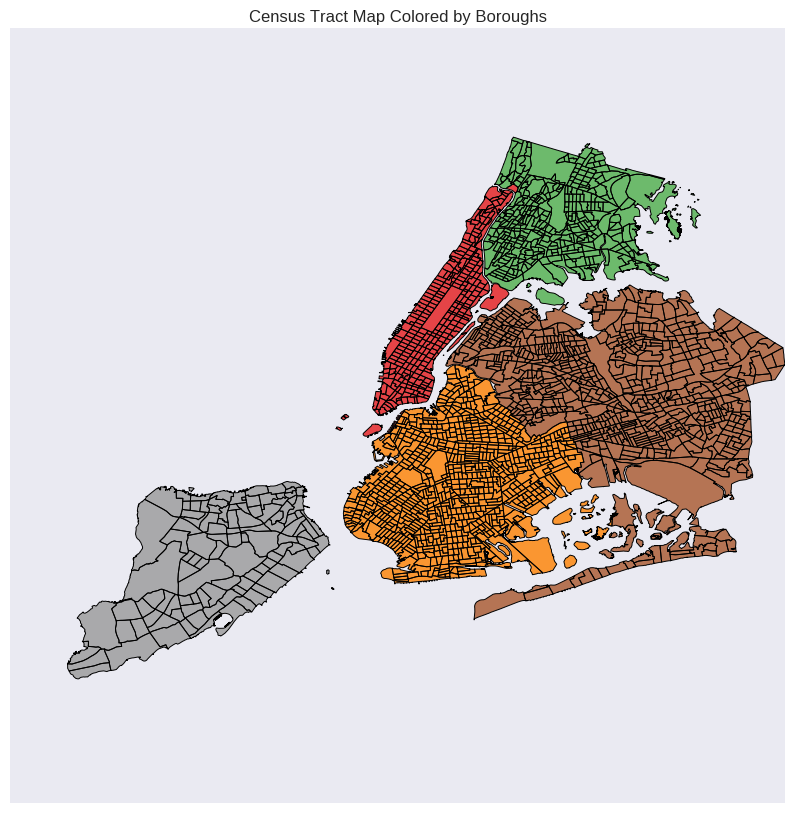

In [5]:
#Visualize the ct (census tract) land boundaries

f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape.plot(column='BoroCode', alpha=0.8, linewidth=0.7, ax=ax)
plt.title("Census Tract Map Colored by Boroughs")

In [6]:
#NYC Population Density Map Using Census Data for year 2010
ct_data = DataFrame.from_csv("ACS_CT2010.csv")
#index setting as BoroCT2010
ct_data.index = ct_data.BoroCT2010.astype(str)

In [7]:
#Adding Population Density to CT ShapeFile with join method usinig  social explorer
ct_shape_pop = ct_shape.join(ct_data[['SE_T002_002']])



/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/geopandas/plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)


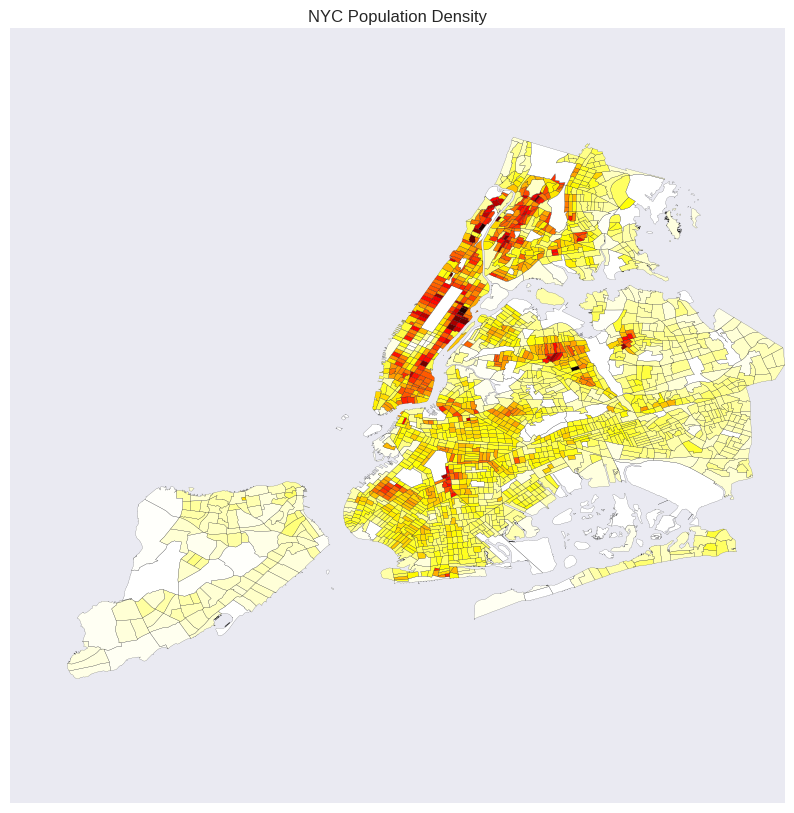

In [8]:
#Visualize the Popilation density for 2010
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape_pop.plot(column='SE_T002_002', colormap='hot_r', alpha=1, linewidth=0.1, ax=ax)
plt.title("NYC Population Density")

In [9]:
#Citybike Data
df_bike_monthly = DataFrame.from_csv('CitiBike_monthly_byStation.csv')
df_bike_monthly.head()

,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,...,1533,1534,1535,1536,1537,1538,1539,1540,1541,1542
starttime,,,,,,,,,,,,,,,,,,,,,
2013-07-31,2343,3914,6979,2750,4914,2229,2183,3139,3622,2368,...,0,0,0,0,0,0,0,0,0,0
2013-08-31,2696,4429,9020,3433,6645,2768,2761,3422,4271,2910,...,0,0,0,0,0,0,0,0,0,0
2013-09-30,2878,5258,9814,3739,7837,3206,2747,3590,4618,2885,...,0,0,0,0,0,0,0,0,0,0
2013-10-31,2920,4409,10456,3520,8928,3237,2530,3909,4169,2542,...,0,0,0,0,0,0,0,0,0,0
2013-11-30,1883,2731,6384,2446,5201,2085,1415,2727,3146,1539,...,0,0,0,0,0,0,0,0,0,0


In [10]:
# Seperated Data for Summer and Winter

#Summer
df_bike_summer = df_bike_monthly.iloc[[0,1,2,9,10,11,12,13,14,21,22,23,24,25,26,33,34,35]]

#Winter
df_bike_winter = df_bike_monthly.iloc[[3,4,5,6,7,8,15,16,17,18,19,20,27,28,29,30,31,32], :]








/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:7: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.


(-200, 16000)

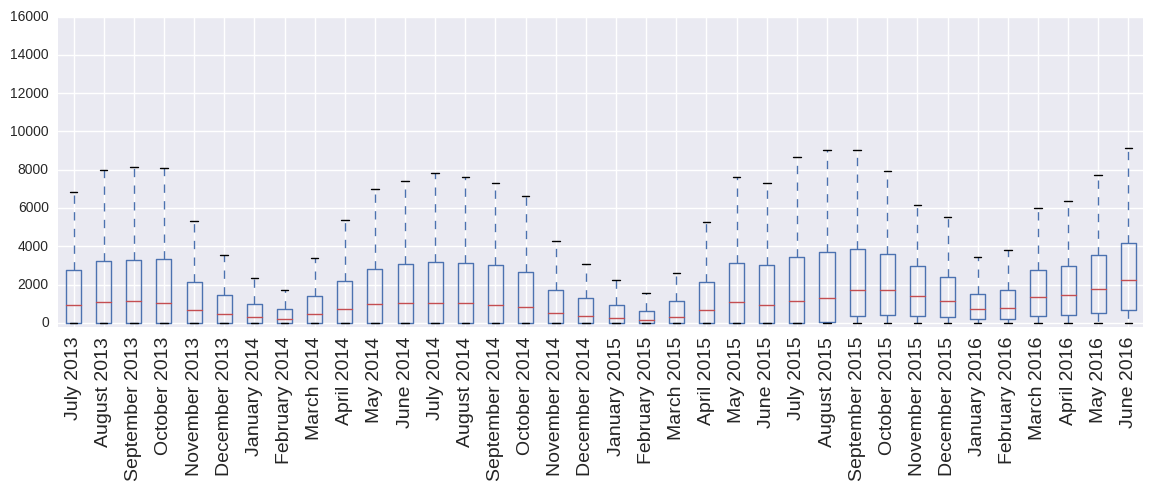

In [11]:
# Time Series Analysis
plt.rcParams['font.size']=14
f, ax = plt.subplots(figsize=(14,4))
#create a copy of the df for visualization
df_bike_monthly_=df_bike_monthly.copy()
df_bike_monthly_.index=df_bike_monthly_.index.strftime("%B %Y")
df_bike_monthly_.T.boxplot(figsize=(15,7), ax=ax,rot=90);
ax.set_ylim([-200, 16000])




/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:9: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.


(-200, 10000)

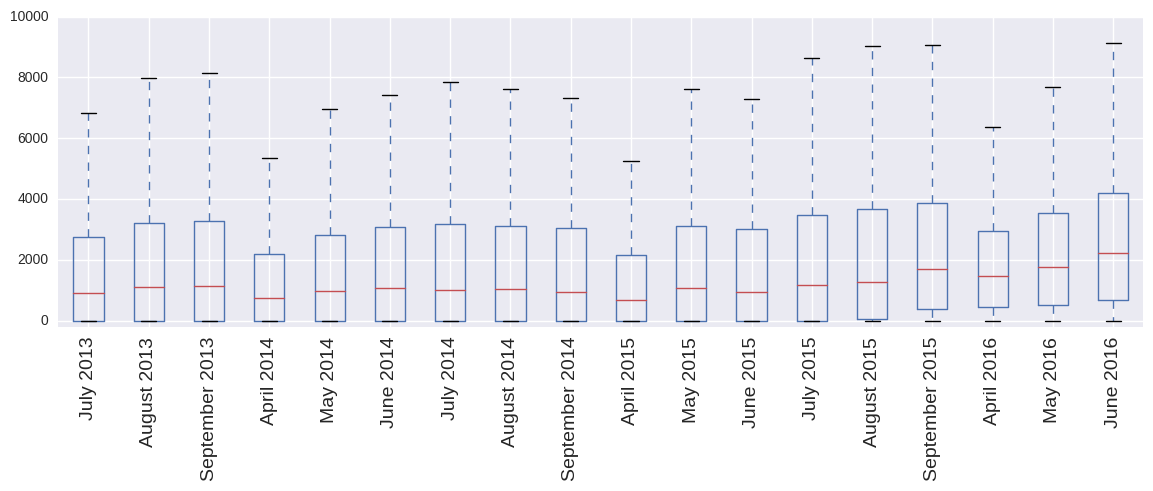

In [12]:
#Summer Months

plt.rcParams['font.size']=14
f, ax = plt.subplots(figsize=(14,4))
#copy for visualization
df_bike_summer_=df_bike_summer.copy()

df_bike_summer_.index=df_bike_summer_.index.strftime("%B %Y")
df_bike_summer_.T.boxplot(figsize=(15,7), ax=ax, rot=90);
ax.set_ylim([-200,10000])



/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.


(-200, 10000)

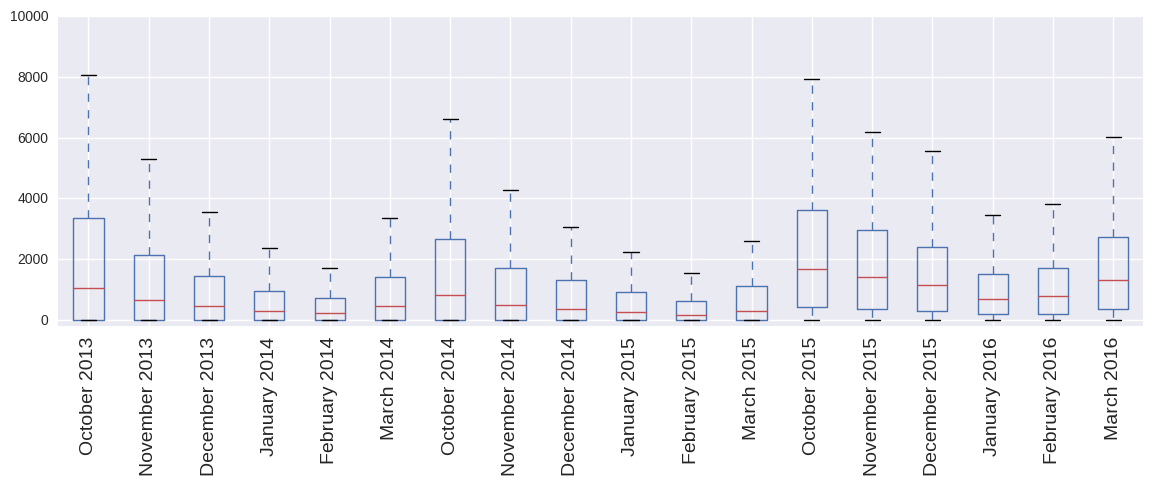

In [13]:
# Winter
plt.rcParams['font.size']=14
f, ax = plt.subplots(figsize=(14,4))
df_bike_winter_=df_bike_winter.copy()
df_bike_winter_.index=df_bike_winter_.index.strftime("%B %Y")
df_bike_winter_.T.boxplot(figsize=(15,7), ax=ax, rot=90);
ax.set_ylim([-200, 10000])

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/statsmodels/tsa/filters/filtertools.py:28: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return np.r_[[np.nan] * head, x, [np.nan] * tail]


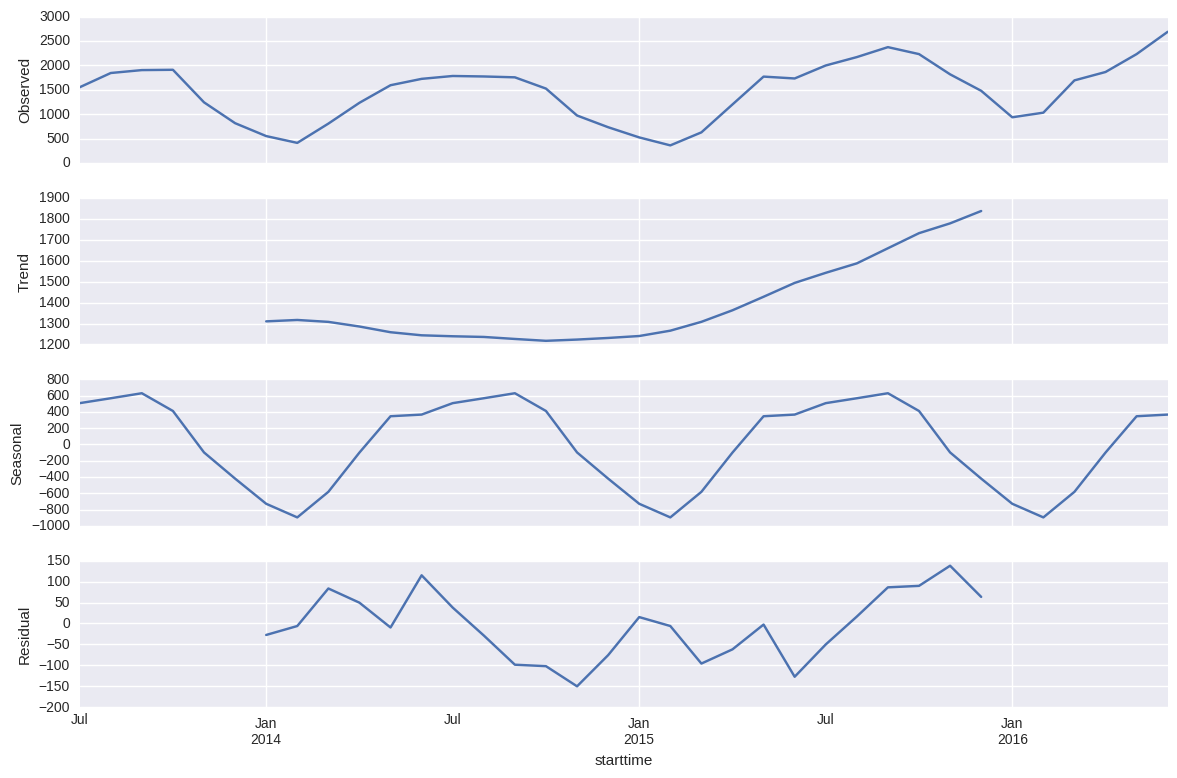

In [14]:
#Seasonal Decomposition

#Create a monthly time series of bike ride with average of all citibike stations
df_new=df_bike_monthly.mean(1).resample('M').mean()
df_new.interpolate(inplace=True)
#seasonal Decomposition using statsmodel api
res = sm.tsa.seasonal_decompose(df_new.dropna())
plt.rcParams['figure.figsize']=(12,8)
resplot = res.plot()

#this only works with PUI2016_Python2


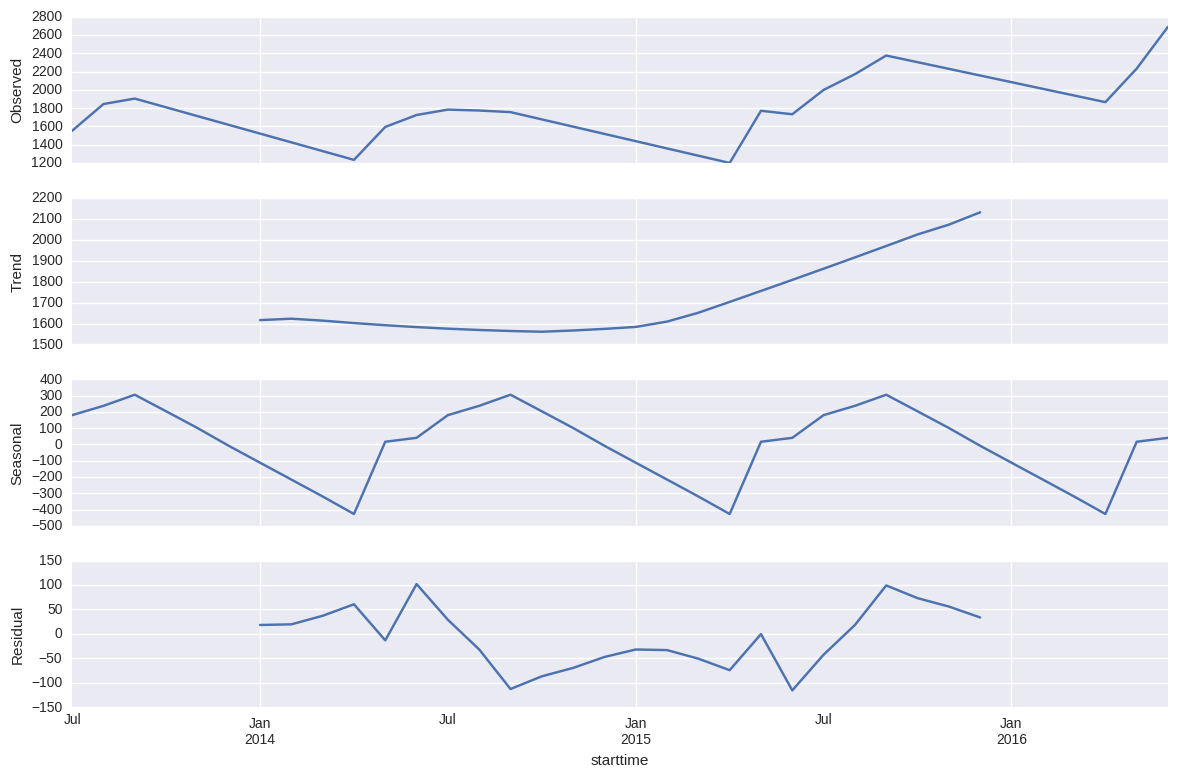

In [15]:
#Monthly time series for summer using average of all bike stations
df_new_S=df_bike_summer.mean(1).resample('M').mean()
df_new_S.interpolate(inplace=True)

#Seasonal decomposition using statmodels api
res = sm.tsa.seasonal_decompose(df_new_S.dropna())
plt.rcParams['figure.figsize']=(12,8)
resplot = res.plot()


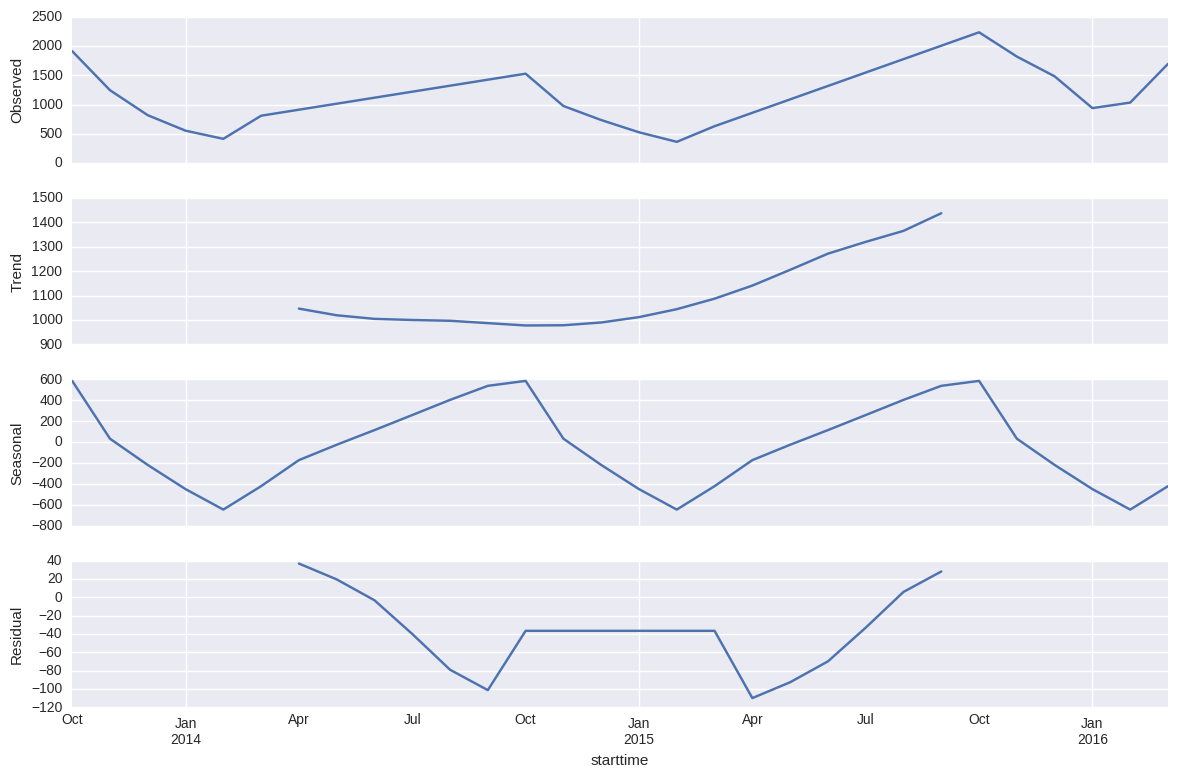

In [16]:
# Time series for winter months
df_new_W = df_bike_winter.mean(1).resample('M').mean()
df_new_W.interpolate(inplace=True)

#Decomposition using statsmodel api
res = sm.tsa.seasonal_decompose(df_new_W.dropna())
plt.rcParams['figure.figsize']=(12,8)
resplot = res.plot()



In [17]:
# Mapping citibike data to Census tract
station_id=DataFrame.from_csv("Station_id.csv")
#convert station_ids to string index
station_id.index=station_id.index.astype(str)
station_id.head()




,lat,lon
1000,40.753231,-73.970325
1001,40.749718,-74.002950
1002,40.730287,-73.990765
1003,40.718939,-73.992663
1004,40.734927,-73.992005


In [18]:
#Create Citibike station gemoetry (point) from Coordinates (lat&lon)
station_id['lonlat'] = zip(station_id.lon, station_id.lat)
#create point geometry based on the new lonlat column
station_id['geometry']=station_id[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))
station_id.head()


,lat,lon,lonlat,geometry
1000,40.753231,-73.970325,"(-73.97032517, 40.75323098)",POINT (-73.97032517 40.75323098)
1001,40.749718,-74.002950,"(-74.002950346, 40.749717753)",POINT (-74.00295034600001 40.749717753)
1002,40.730287,-73.990765,"(-73.9907647, 40.73028666)",POINT (-73.9907647 40.73028666)
1003,40.718939,-73.992663,"(-73.99266288, 40.71893904)",POINT (-73.99266288 40.71893904)
1004,40.734927,-73.992005,"(-73.99200509, 40.73492695)",POINT (-73.99200509000001 40.73492695)


In [19]:
#intersect the two geometries
a=[]
#for loop to check the data for citibike locations within census tract

for i in range(len(station_id)):
    a.append(ct_shape[ct_shape.geometry.intersects(station_id.iloc[i].geometry)]. BoroCT2010.values[0])
    print '\r', '%', str((i+1)*100./len(station_id))[:4],
station_id['BoroCT2010']=a




% 100.


In [20]:
station_id.BoroCT2010.head()

1000    1009000
1001    1009900
1002    1005700
1003    1001800
1004    1006100
Name: BoroCT2010, dtype: object

In [21]:
# Combine Monthly rides to the station GeoDataFrame wuth CT Code
station_id['Monthly_Avg'] = df_bike_monthly.sum()
station_id['Summer_Avg'] = df_bike_summer.sum()
station_id['Winter_Avg'] = df_bike_winter.sum()



In [22]:
station_id.head()

,lat,lon,lonlat,geometry,BoroCT2010,Monthly_Avg,Summer_Avg,Winter_Avg
1000,40.753231,-73.970325,"(-73.97032517, 40.75323098)",POINT (-73.97032517 40.75323098),1009000,69308,42378,26930
1001,40.749718,-74.002950,"(-74.002950346, 40.749717753)",POINT (-74.00295034600001 40.749717753),1009900,102824,67646,35178
1002,40.730287,-73.990765,"(-73.9907647, 40.73028666)",POINT (-73.9907647 40.73028666),1005700,273525,169085,104440
1003,40.718939,-73.992663,"(-73.99266288, 40.71893904)",POINT (-73.99266288 40.71893904),1001800,101949,64084,37865
1004,40.734927,-73.992005,"(-73.99200509, 40.73492695)",POINT (-73.99200509000001 40.73492695),1006100,184044,116324,67720


In [ ]:
temp=station_id[['Monthly_Avg', 'Summer_Avg', 'Winter_Avg']]
temp['station_id']=station_id.index
temp.index=station_id['BoroCT2010']
ct_shape_MonthlyAvg=ct_shape.join(temp)
ct_shape_MonthlyAvg.fillna(0,inplace=True)

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [ ]:
# Monthly Average Rides 
f, ax = plt.subplots(figsize=(10,10))
ct_shape_MonthlyAvg.plot(column='Monthly_Avg',colormap='YlGn',alpha=1,linewidth=0.1,ax=ax)
plt.title("Monthly Ride Counts")

In [ ]:
#Summer time rides
f, ax = plt.subplots(figsize=(10,10))
ct_shape_MonthlyAvg.plot(column='Summer_Avg',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax)
plt.title("Summer Ride Counts")


In [ ]:
#Winter Time Rides
f, ax = plt.subplots(figsize=(10,10))
ct_shape_MonthlyAvg.plot(column='Winter_Avg',colormap='Blues',alpha=1,linewidth=0.1,ax=ax)
plt.title("Winter Ride Counts")



In [ ]:
# Trimming Census Data not overlapping with the Citibike Usage Area 
ct_shape_MonthlyAvg_Zoom=(ct_shape_MonthlyAvg[ct_shape_MonthlyAvg
                           .centroid
                           .apply(lambda c:c.x>-74.1 and c.x<-73.92 and c.y>40.65 and c.y<40.8)])

In [ ]:
# Keeping Summer and winter lengths equal
print "Total number of CTs:", len(ct_shape)
print "Number of zoomed CTs:", len(temp.Summer_Avg) 


In [ ]:
#Enlrage map for rides for all months
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape_MonthlyAvg_Zoom.plot(column='Monthly_Avg',colormap='YlGn',alpha=1,linewidth=0.1,ax=ax)
plt.title("Monthly Ride Counts")

In [ ]:
#Enlarge for summer monthly Rides
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape_MonthlyAvg_Zoom.plot(column='Summer_Avg',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax)
plt.title("Summer Ride Counts")



In [ ]:
#Enlarge for Winter monthly Rides
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape_MonthlyAvg_Zoom.plot(column='Winter_Avg',colormap='Blues',alpha=1,linewidth=0.1,ax=ax)
plt.title("Winter Ride Counts")


In [ ]:
#Export Shapefile CTs in the CitiBike Zone
path = "ct_shape_MonthlyAvg_Zoom.shp"
ct_shape_MonthlyAvg_Zoom.to_file(path)


In [ ]:
#Exploratory Spatial Weighs: Quuens 
qW_CT=ps.queen_from_shapefile(path)



In [ ]:
#Neighbors Index 10
qW_CT[10]


In [ ]:
qW_CT.cardinalities[10]

In [ ]:
#matrix of Weights
Wmatrix, ids = qW_CT.full()


In [ ]:
Wmatrix

In [ ]:
#Change the matrix to be row-standardized
qW_CT.transform = 'r'


In [ ]:
#Spatial lag
# Lags for Monthly, Summer, and Winter Rides:

# MONTHLY:

monthly_Ride = ct_shape_MonthlyAvg_Zoom.Monthly_Avg
monthly_Ride_Lag = ps.lag_spatial(qW_CT, monthly_Ride)


# SUMMER:

summer_Ride = ct_shape_MonthlyAvg_Zoom.Summer_Avg
summer_Ride_Lag = ps.lag_spatial(qW_CT, summer_Ride)

# WINTER:

winter_Ride = ct_shape_MonthlyAvg_Zoom.Winter_Avg
winter_Ride_Lag = ps.lag_spatial(qW_CT, winter_Ride)

In [ ]:
#Quantiles for mapping Summer and Winter
monthlyRideLagQ10 = ps.Quantiles(monthly_Ride_Lag, k = 10)
summerRideLagQ10 = ps.Quantiles(summer_Ride_Lag, k = 10)
winterRideLagQ10 = ps.Quantiles(winter_Ride_Lag, k = 10)

print (monthlyRideLagQ10)
print (summerRideLagQ10)
print (winterRideLagQ10)

In [ ]:
#Map the Monthly, Summer, and Winter Lags
# MONTHLY
f, ax = plt.subplots(figsize=(9, 9))
ct_shape_MonthlyAvg_Zoom.assign(cl=monthlyRideLagQ10.yb).plot(column='cl', categorical=True, 
        k=10, cmap='YlGn', linewidth=0.1, ax=ax, 
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("Monthly Ride Spatial Lag Deciles")


In [ ]:
# SUMMER
f, ax = plt.subplots(figsize=(9, 9))
ct_shape_MonthlyAvg_Zoom.assign(cl=summerRideLagQ10.yb).plot(column='cl', categorical=True, 
        k=10, cmap='hot_r', linewidth=0.1, ax=ax, 
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("Summer Ride Spatial Lag Deciles")

In [ ]:
# WINTER
f, ax = plt.subplots(figsize=(9, 9))
ct_shape_MonthlyAvg_Zoom.assign(cl=winterRideLagQ10.yb).plot(column='cl', categorical=True, 
        k=10, cmap='Blues', linewidth=0.1, ax=ax, 
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("Winter Ride Spatial Lag Deciles")

In [ ]:
# Global Geospatial AutoCorrelation 

b1,a1 = np.polyfit(monthly_Ride, monthly_Ride_Lag, 1)  # all months
b2,a2 = np.polyfit(summer_Ride, summer_Ride_Lag, 1)  # summer
b3,a3 = np.polyfit(winter_Ride, winter_Ride_Lag, 1)  # winter

print (b1,a1) 
print (b2,a2) 
print (b3,a3)

In [ ]:
#Moran Scatterplot - All Months

f, ax = plt.subplots(1, figsize=(9, 9))

plt.plot(monthly_Ride, monthly_Ride_Lag, '.', color='green')

 # dashed vert at mean of the last year's PCI
plt.vlines(monthly_Ride.mean(), monthly_Ride_Lag.min(), monthly_Ride_Lag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(monthly_Ride_Lag.mean(), monthly_Ride.min(), monthly_Ride.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(monthly_Ride, a1 + b1*monthly_Ride, 'g')
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of Summer Rides')
plt.xlabel('Monthly Rides')


In [ ]:
#Moran Scatterplot - Summer

f, ax = plt.subplots(1, figsize=(9, 9))

plt.plot(summer_Ride, summer_Ride_Lag, '.', color='firebrick')

 # dashed vert at mean of the last year's PCI
plt.vlines(summer_Ride.mean(), summer_Ride_Lag.min(), summer_Ride_Lag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(summer_Ride_Lag.mean(), summer_Ride.min(), summer_Ride.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(summer_Ride, a2 + b2*summer_Ride, 'r')
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of Summer Rides')
plt.xlabel('Summer Rides')

In [ ]:
#Moran Scatterplot - Winter

f, ax = plt.subplots(1, figsize=(9, 9))

plt.plot(winter_Ride, winter_Ride_Lag, '.', color='blue')

 # dashed vert at mean of the last year's PCI
plt.vlines(winter_Ride.mean(), winter_Ride_Lag.min(), winter_Ride_Lag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(winter_Ride_Lag.mean(), winter_Ride.min(), winter_Ride.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(winter_Ride, a3 + b3*winter_Ride, 'b')
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of Winter Rides')
plt.xlabel('Winter Rides')

In [ ]:
#Moran's I

monthly_I = ps.Moran(monthly_Ride, qW_CT) # All Months
summer_I = ps.Moran(summer_Ride, qW_CT)   # Summer
winter_I = ps.Moran(winter_Ride, qW_CT)   # Winter





In [ ]:
print(monthly_I.I, monthly_I.p_sim) # All Months
print(summer_I.I, summer_I.p_sim) # Summer
print(winter_I.I, winter_I.p_sim) # Winter

In [ ]:
print (monthly_I.sim[0:10])  # All Months
print (summer_I.sim[0:10])  # Summer
print (winter_I.sim[0:10])  # Winter

In [ ]:
#KDEplot of all of the simulated points - Summer and Winter
#the vertical line shows the observed value
plt.rcParams['figure.figsize']=(14,3)


In [ ]:
# KDE plots - All Months
sns.kdeplot(monthly_I.sim, shade=True)
plt.vlines(monthly_I.sim, 0, 1)
plt.vlines(monthly_I.I, 0, 10, 'g')
plt.xlim([-.70, .70])

In [ ]:
sns.kdeplot(monthly_I.sim, shade=True)
plt.vlines(monthly_I.sim, 0, 1)
plt.vlines(monthly_I.EI+.01, 0, 10, 'g')
plt.xlim([-.70, .70])

In [ ]:
# KDE plots - Summer
sns.kdeplot(summer_I.sim, shade=True)
plt.vlines(summer_I.sim, 0, 1)
plt.vlines(summer_I.I, 0, 10, 'r')
plt.xlim([-.70, .70])

In [ ]:
sns.kdeplot(summer_I.sim, shade=True)
plt.vlines(summer_I.sim, 0, 1)
plt.vlines(summer_I.EI+.01, 0, 10, 'r')
plt.xlim([-.70, .70])

In [ ]:
# KDE plots - Winter
sns.kdeplot(winter_I.sim, shade=True)
plt.vlines(winter_I.sim, 0, 1)
plt.vlines(winter_I.I, 0, 10, 'b')
plt.xlim([-.70, .70])

In [ ]:
sns.kdeplot(winter_I.sim, shade=True)
plt.vlines(winter_I.sim, 0, 1)
plt.vlines(winter_I.EI+.01, 0, 10, 'b')
plt.xlim([-.70, .70])

In [ ]:
#Local Spatial Autocorrelation

LMo_MonthlyRide = ps.Moran_Local(monthly_Ride, qW_CT, permutations = 999) # All Months
LMo_SummerRide = ps.Moran_Local(summer_Ride, qW_CT, permutations=999) # Summer
LMo_WinterRide = ps.Moran_Local(winter_Ride, qW_CT, permutations=999) # Winter


In [ ]:
LMo_MonthlyRide.Is[0:5], LMo_MonthlyRide.p_sim[0:5]

In [ ]:
LMo_SummerRide.Is[0:5], LMo_SummerRide.p_sim[0:5]

In [ ]:
LMo_WinterRide.Is[0:5], LMo_WinterRide.p_sim[0:5]

In [ ]:
#LISA (Local Indicators of Spatial Autocorrelation)

#all months

sigs_A = monthly_Ride[LMo_MonthlyRide.p_sim <= .001]
W_sigs_A = monthly_Ride_Lag[LMo_MonthlyRide.p_sim <= .001]
insigs_A = monthly_Ride[LMo_MonthlyRide.p_sim > .001]
W_insigs_A = monthly_Ride_Lag[LMo_MonthlyRide.p_sim > .001]



In [ ]:
#Summer Months

sigs_S = summer_Ride[LMo_SummerRide.p_sim <= .001]
W_sigs_S = summer_Ride_Lag[LMo_SummerRide.p_sim <= .001]
insigs_S = summer_Ride[LMo_SummerRide.p_sim > .001]
W_insigs_S = summer_Ride_Lag[LMo_SummerRide.p_sim > .001]


In [ ]:
#Winter months

sigs_W = winter_Ride[LMo_WinterRide.p_sim <= .001]
W_sigs_W = winter_Ride_Lag[LMo_WinterRide.p_sim <= .001]
insigs_W = winter_Ride[LMo_WinterRide.p_sim > .001]
W_insigs_W = winter_Ride_Lag[LMo_WinterRide.p_sim > .001]


In [ ]:
#Plot Signficant LISA
#All  months

f, ax = plt.subplots(figsize=(9, 9))
plt.plot(sigs_A, W_sigs_A, '.', color='green')
plt.plot(insigs_A, W_insigs_A, '.k', alpha=.2)
plt.text(s='$I = %.3f$' % monthly_I.I, x=120000, y=5000, fontsize=18)

 # dashed vert at mean of the last year's PCI
plt.vlines(monthly_Ride.mean(), monthly_Ride_Lag.min(), monthly_Ride_Lag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(monthly_Ride_Lag.mean(), monthly_Ride.min(), monthly_Ride.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(monthly_Ride, a1 + b1*monthly_Ride, 'g')
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of MonthlyRides')
plt.xlabel('MonthlyRides')

In [ ]:
#Summer Months

f, ax = plt.subplots(figsize=(9, 9))
plt.plot(sigs_S, W_sigs_S, '.', color='firebrick')
plt.plot(insigs_S, W_insigs_S, '.k', alpha=.2)
plt.text(s='$I = %.3f$' % summer_I.I, x=120000, y=5000, fontsize=18)

 # dashed vert at mean of the last year's PCI
plt.vlines(summer_Ride.mean(), summer_Ride_Lag.min(), summer_Ride_Lag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(summer_Ride_Lag.mean(), summer_Ride.min(), summer_Ride.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(summer_Ride, a2 + b2*summer_Ride, 'r')
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of SummerRides')
plt.xlabel('SummerRides')

In [ ]:
#winter Months
, ax = plt.subplots(figsize=(9, 9))
plt.plot(sigs_W, W_sigs_W, '.', color='blue')
plt.plot(insigs_W, W_insigs_W, '.k', alpha=.2)
plt.text(s='$I = %.3f$' % winter_I.I, x=120000, y=5000, fontsize=18)

 # dashed vert at mean of the last year's PCI
plt.vlines(winter_Ride.mean(), winter_Ride_Lag.min(), winter_Ride_Lag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(winter_Ride_Lag.mean(), winter_Ride.min(), winter_Ride.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(winter_Ride, a3 + b3*winter_Ride, 'b')
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of WinterRides')
plt.xlabel('WinterRides')

In [ ]:
#Hot and Cold Spots
#All months
sig_A = LMo_MonthlyRide.p_sim < 0.01
hotspots_A = LMo_MonthlyRide.q==1 * sig_A
coldspots_A = LMo_MonthlyRide.q==3 * sig_A
print "Number of Hotspots:", hotspots_A.sum()
print "Number of Coldspots:", coldspots_A.sum()



In [ ]:
hcmap_A = colors.ListedColormap(['grey','red','blue'])
hotcold_A = hotspots_A*1 + coldspots_A*2

f, ax = plt.subplots(figsize=(9, 9))
ct_shape_MonthlyAvg_Zoom.assign(cl=hotcold_A).plot(column='cl', categorical=True, 
        k=10, cmap=hcmap_A, linewidth=0.1, ax=ax, 
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("MonthlyAvg Spatial Lag Deciles")

In [ ]:
#Summer months

sig_S = LMo_SummerRide.p_sim < 0.01
hotspots_S = LMo_SummerRide.q==1 * sig_S
coldspots_S = LMo_SummerRide.q==3 * sig_S
print "Number of Hotspots:", hotspots_S.sum()
print "Number of Coldspots:", coldspots_S.sum()

In [ ]:
hcmap_S = colors.ListedColormap(['grey','red','blue'])
hotcold_S = hotspots_S*1 + coldspots_S*2

f, ax = plt.subplots(figsize=(9, 9))
ct_shape_MonthlyAvg_Zoom.assign(cl=hotcold_S).plot(column='cl', categorical=True, 
        k=10, cmap=hcmap_S, linewidth=0.1, ax=ax, 
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("SummerAvg Spatial Lag Deciles")

In [ ]:
#Winter months

sig_W = LMo_WinterRide.p_sim < 0.01
hotspots_W = LMo_SummerRide.q==1 * sig_W
coldspots_W = LMo_SummerRide.q==3 * sig_W
print "Number of Hotspots:", hotspots_W.sum()
print "Number of Coldspots:", coldspots_W.sum()


In [ ]:
hcmap_W = colors.ListedColormap(['grey','red','blue'])
hotcold_W = hotspots_W*1 + coldspots_W*2

f, ax = plt.subplots(figsize=(9, 9))
ct_shape_MonthlyAvg_Zoom.assign(cl=hotcold_W).plot(column='cl', categorical=True, 
        k=10, cmap=hcmap_W, linewidth=0.1, ax=ax, 
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("WinterAvg Spatial Lag Deciles")